Import packages

In [204]:
import numpy as np
import pandas as pd
import glob
import os.path
import datetime
import os
import matplotlib.pyplot as plt
from geopy.distance import geodesic  # For distance calculation

See Data

In [205]:
for dirname, _, filenames in os.walk('Geolife_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Geolife_data/.DS_Store
Geolife_data/User37/16720081125014100.plt
Geolife_data/User37/16720080915202231.plt
Geolife_data/User37/16720081008180829.plt
Geolife_data/User37/16720080520012328.plt
Geolife_data/User37/16720081129045105.plt
Geolife_data/User37/16720081128115427.plt
Geolife_data/User37/16720080914090038.plt
Geolife_data/User37/16720080718020353.plt
Geolife_data/User37/16720080503160104.plt
Geolife_data/User37/16720081203021423.plt
Geolife_data/User37/16720080606181635.plt
Geolife_data/User37/16720080522013504.plt
Geolife_data/User37/16720080508013105.plt
Geolife_data/User37/16720080627173305.plt
Geolife_data/User37/16720080426043723.plt
Geolife_data/User37/16720080602011704.plt
Geolife_data/User37/16720080706052159.plt
Geolife_data/User37/16720080328095216.plt
Geolife_data/User37/16720080812021854.plt
Geolife_data/User37/16720080605015658.plt
Geolife_data/User37/16720080820120327.plt
Geolife_data/User37/16720080519003252.plt
Geolife_data/User37/16720080709040859.plt
Geolife_dat

Function for reading data from .plt files

In [206]:
def read_plt(plt_file):
    #print(f"Processing file: {plt_file}")
     # Determine if the file has a header
    with open(plt_file, "r") as file: first_line = file.readline().strip()
    #print (first_line[0])
    has_header = not first_line[0].isdigit()   #auslesen ob es einen header gibt
    #print(has_header)
    points = pd.read_csv(plt_file,
                        skiprows=1 if has_header else 0,     #erste Zeile überspringen wenn es einen header gibt
                        header=None,        #hier war auf 6 wegen dem was in den orginal datensatz alles da steht
                        #parse=[[5, 6]]  #veraltet
                        #infer_datetime_format=True)  #veraltet
    )

    # Combine columns 5 (date) and 6 (time) into a single 'time' column
    points['time'] = pd.to_datetime(
        points[5] + " " + points[6],  # Concatenate date and time columns
        format='%Y-%m-%d %H:%M:%S',  # Specify the datetime format
        errors='coerce'  # Handle invalid datetime formats gracefully
    )


    #add column with plt number
    points['trajectory']=os.path.basename(plt_file)

    # for clarity rename columns
    points.rename(inplace=True, columns={'5_6': 'time', 0: 'lat', 1: 'lon', 3: 'alt', 4:'elapsed time', 7: 'label'})  #hier gibt es einen konflikt wenn man unten das label lesen nicht ausklammert
    
    # remove unused columns
    points.drop(inplace=True, columns=[2,5,6])
    #print(points)

    return points

Set mode names and IDs

In [207]:
mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}


If there is a labels file, extract the labels

In [208]:
def read_labels(labels_file):
    labels = pd.read_csv(labels_file, skiprows=1, header=None,
                         parse_dates=[[0, 1], [2, 3]],
                         infer_datetime_format=True, delim_whitespace=True)

   #for clarity rename columns
    labels.columns = ['start_time', 'end_time', 'label']

   #replace 'label' column with integer encoding
    labels['label'] = [mode_ids[i] for i in labels['label']]

    return labels

#def apply_labels(points, labels):
    indices = labels['start_time'].searchsorted(points['time'], side='right') - 1
    no_label = (indices < 0) | (points['time'].values >= labels['end_time'].iloc[indices].values)
    points['label'] = labels['label'].iloc[indices].values
    points['label'][no_label] = 0

Put together data for all the users

In [209]:
def read_user(user_folder):
    labels = None

    plt_files = glob.glob(os.path.join(user_folder, '*.plt'))    #'Trajectory' folder raus
    df = pd.concat([read_plt(f) for f in plt_files])

    #labels_file = os.path.join(user_folder, 'labels.txt')    #ich glaub das hier ist alles unnötig weil ich nur welche mit labels hab
    #if os.path.exists(labels_file):
    #    labels = read_labels(labels_file)
    #    apply_labels(df, labels)
    #else:
    #    df['label'] = 0
    return df

Read data from all users

In [210]:
def read_all_users(folder):
    subfolders = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f)) and not f.startswith('.')] #damit ds._store nicht gemacht wird
    dfs = []
    for i, sf in enumerate(subfolders):
        print('[%d/%d] processing user %s' % (i + 1, len(subfolders), sf))
        df = read_user(os.path.join(folder,sf))
        df['user'] = int(sf.replace("User", ""))  #hier änderung weil "user" bei ihrem datensatz davor steht
        dfs.append(df)
    return pd.concat(dfs)

Execute the data reading

In [211]:
df = read_all_users('Geolife_data')
df

[1/38] processing user User37
[2/38] processing user User30
[3/38] processing user User31
[4/38] processing user User36
[5/38] processing user User38
[6/38] processing user User2
[7/38] processing user User5
[8/38] processing user User4
[9/38] processing user User3
[10/38] processing user User25
[11/38] processing user User22
[12/38] processing user User14
[13/38] processing user User13
[14/38] processing user User12
[15/38] processing user User15
[16/38] processing user User23
[17/38] processing user User24
[18/38] processing user User33
[19/38] processing user User34
[20/38] processing user User35
[21/38] processing user User32
[22/38] processing user User8
[23/38] processing user User6
[24/38] processing user User1
[25/38] processing user User7
[26/38] processing user User9
[27/38] processing user User21
[28/38] processing user User26
[29/38] processing user User19
[30/38] processing user User10
[31/38] processing user User17
[32/38] processing user User28
[33/38] processing user Us

,lat,lon,alt,elapsed time,label,time,trajectory,user
0,40.006871,116.320977,84.0,39777.195949,bike,2008-11-25 04:42:10,16720081125014100.plt,37
1,40.006913,116.321023,71.0,39777.195972,bike,2008-11-25 04:42:12,16720081125014100.plt,37
2,40.006878,116.321002,69.0,39777.195995,bike,2008-11-25 04:42:14,16720081125014100.plt,37
3,40.006885,116.320996,74.0,39777.196019,bike,2008-11-25 04:42:16,16720081125014100.plt,37
4,40.006934,116.321002,75.0,39777.196042,bike,2008-11-25 04:42:18,16720081125014100.plt,37
...,...,...,...,...,...,...,...,...
794,39.978615,116.304728,0.0,40813.107130,bike,2011-09-27 02:34:16,02020110927021725.plt,20
795,39.978598,116.304693,0.0,40813.107141,bike,2011-09-27 02:34:17,02020110927021725.plt,20
796,39.978597,116.304672,0.0,40813.107153,bike,2011-09-27 02:34:18,02020110927021725.plt,20
797,39.978597,116.304652,0.0,40813.107164,bike,2011-09-27 02:34:19,02020110927021725.plt,20


 Convert 'time' column to datetime type

In [212]:
df['time'] = pd.to_datetime(df['time'])
df

,lat,lon,alt,elapsed time,label,time,trajectory,user
0,40.006871,116.320977,84.0,39777.195949,bike,2008-11-25 04:42:10,16720081125014100.plt,37
1,40.006913,116.321023,71.0,39777.195972,bike,2008-11-25 04:42:12,16720081125014100.plt,37
2,40.006878,116.321002,69.0,39777.195995,bike,2008-11-25 04:42:14,16720081125014100.plt,37
3,40.006885,116.320996,74.0,39777.196019,bike,2008-11-25 04:42:16,16720081125014100.plt,37
4,40.006934,116.321002,75.0,39777.196042,bike,2008-11-25 04:42:18,16720081125014100.plt,37
...,...,...,...,...,...,...,...,...
794,39.978615,116.304728,0.0,40813.107130,bike,2011-09-27 02:34:16,02020110927021725.plt,20
795,39.978598,116.304693,0.0,40813.107141,bike,2011-09-27 02:34:17,02020110927021725.plt,20
796,39.978597,116.304672,0.0,40813.107153,bike,2011-09-27 02:34:18,02020110927021725.plt,20
797,39.978597,116.304652,0.0,40813.107164,bike,2011-09-27 02:34:19,02020110927021725.plt,20


# Group the data by trajectory (file path) to visualize each trajectory separately

In [213]:
trajectories = df.groupby('trajectory')

Set up the plot

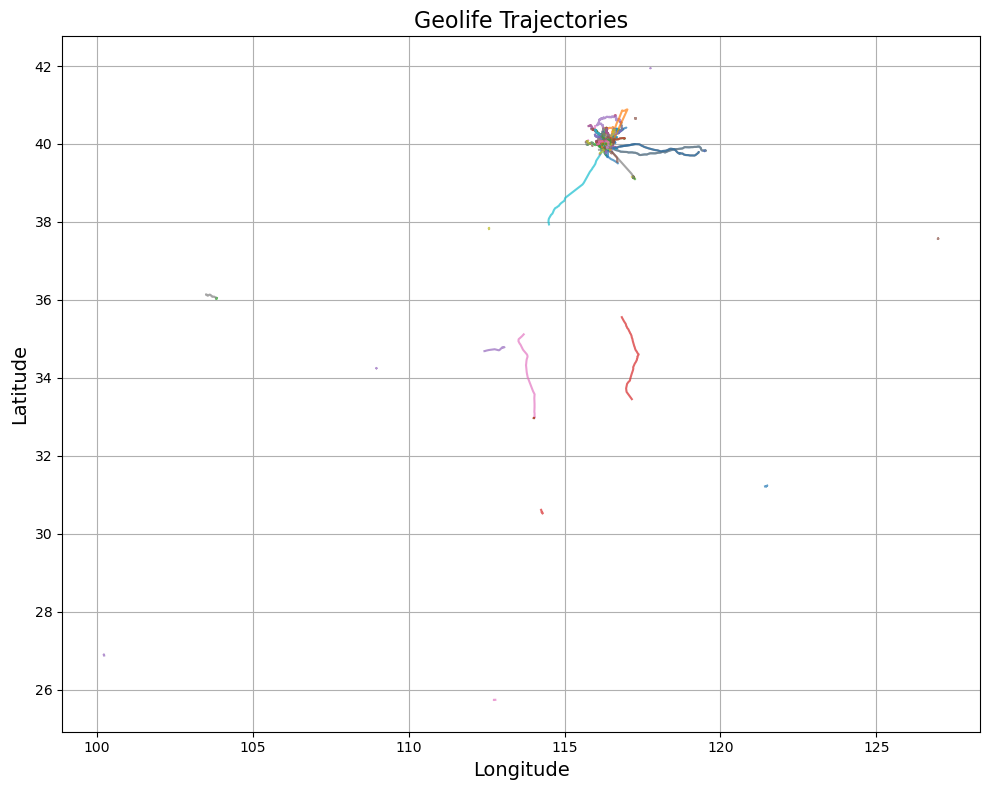

In [214]:
plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Plot each trajectory
for name, group in trajectories:
    plt.plot(group['lon'], group['lat'], label=name.split('/')[-1], alpha=0.7)

# Add a legend
#plt.legend(title="Trajectory File", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.grid()

# Save the plot as a file
plt.savefig("geolife_trajectories23.png", dpi=50)

# Show the plot
plt.show()

Set Axis limits

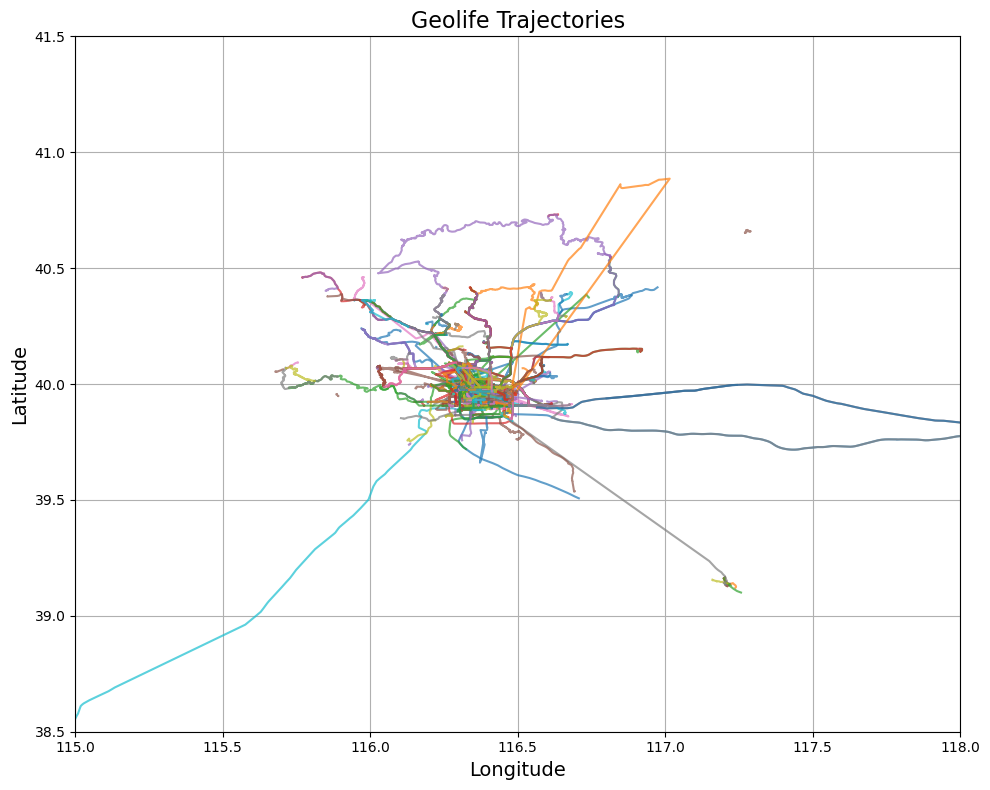

In [215]:
plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(115, 118)  # Longitude limits
plt.ylim(38.5, 41.5)  # Latitude limits

# Plot each trajectory
for name, group in trajectories:
    plt.plot(group['lon'], group['lat'], label=name.split('/')[-1], alpha=0.7)

# Add a legend
#plt.legend(title="Trajectory File", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.grid()

# Save the plot as a file
plt.savefig("geolife_trajectories23.png", dpi=50)

# Show the plot
plt.show()




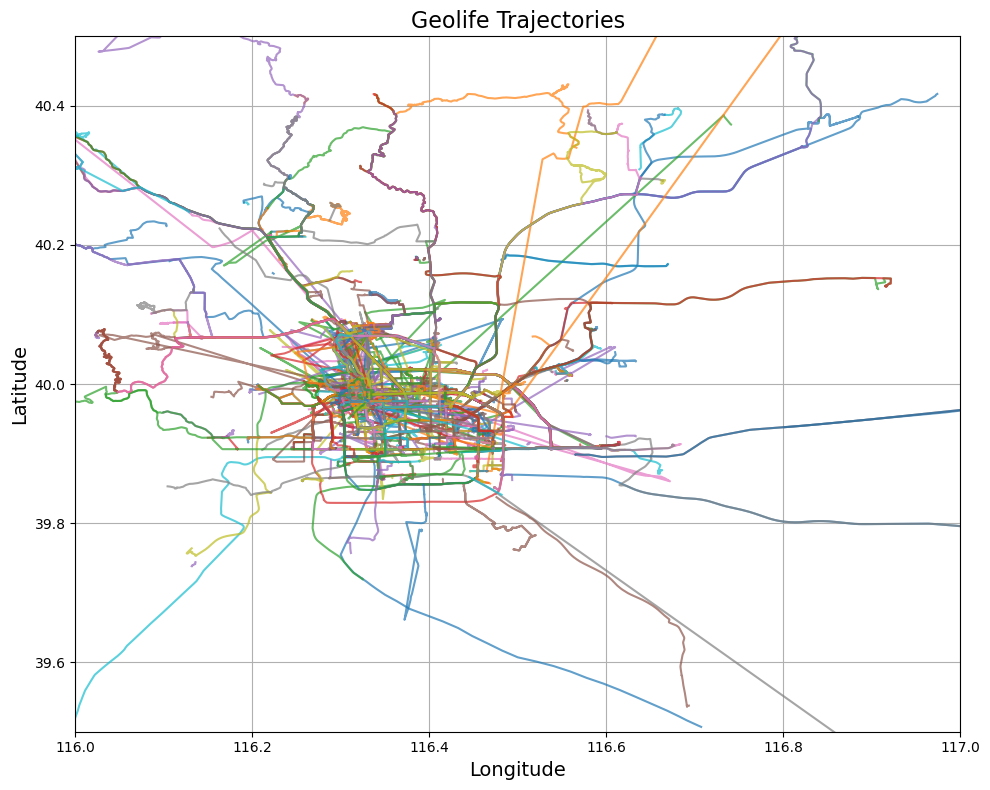

In [216]:
plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116, 117)  # Longitude limits
plt.ylim(39.5, 40.5)  # Latitude limits

# Plot each trajectory
for name, group in trajectories:
    plt.plot(group['lon'], group['lat'], label=name.split('/')[-1], alpha=0.7)

# Add a legend
#plt.legend(title="Trajectory File", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.grid()

# Save the plot as a file
plt.savefig("geolife_trajectories23.png", dpi=1000)

# Show the plot
plt.show()

Extract Features

Sort by trajectory and time

In [217]:
df = df.sort_values(by=['trajectory', 'time'])
df

,lat,lon,alt,elapsed time,label,time,trajectory,user
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33
...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36


Initialize features

In [218]:
df['distance'] = 0.0  # Distance between consecutive points
df['speed'] = 0.0     # Speed between consecutive points


Feature Extraction

In [219]:
df['time_diff'] = df['time'].diff().dt.total_seconds()

In [220]:
df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,0.0,0.0,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.0,0.0,34.0
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.0,0.0,59.0
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.0,0.0,59.0
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.0,0.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.0,0.0,2.0
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.0,0.0,2.0
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.0,0.0,2.0
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.0,0.0,2.0


Initialize Speed and Distance column

In [221]:

df['distance'] = 0.0
df['speed'] = 0.0

Feature extraction for all trajectories

In [222]:
import pandas as pd
from geopy.distance import geodesic
from math import atan2, degrees, sin, cos, sqrt, radians


In [223]:
def calculate_distance(lat1, lon1, lat2, lon2):

    # Convert coordinates to radians using NumPy vectorize
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = 6371 * c             #radius of earth

    return distance



In [224]:
df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,0.0,0.0,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.0,0.0,34.0
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.0,0.0,59.0
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.0,0.0,59.0
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.0,0.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.0,0.0,2.0
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.0,0.0,2.0
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.0,0.0,2.0
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.0,0.0,2.0


Calculate Distances

In [225]:
df['distance'] = calculate_distance(df['lat'].shift().values, df['lon'].shift().values, df['lat'].values, df['lon'].values) #shift nimmt immer den vorherigen?
df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,NaN,0.0,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.252764,0.0,34.0
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.456583,0.0,59.0
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.521027,0.0,59.0
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.673539,0.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.023240,0.0,2.0
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.023262,0.0,2.0
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.023018,0.0,2.0
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.023018,0.0,2.0


Calculate Speed. Hier noch wechseln auf kmh?

In [226]:
df['speed'] = df['distance'] / df['time_diff']
df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,NaN,NaN,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.252764,0.007434,34.0
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.456583,0.007739,59.0
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.521027,0.008831,59.0
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.673539,0.011416,59.0
...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.023240,0.011620,2.0
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.023262,0.011631,2.0
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.023018,0.011509,2.0
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.023018,0.011509,2.0


Calculate acceleration

In [227]:
df['acceleration'] = df['speed'].diff() / df['time_diff']
df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff,acceleration
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,NaN,NaN,NaN,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.252764,0.007434,34.0,NaN
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.456583,0.007739,59.0,5.160437e-06
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.521027,0.008831,59.0,1.851318e-05
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.673539,0.011416,59.0,4.381261e-05
...,...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.023240,0.011620,2.0,-2.799201e-05
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.023262,0.011631,2.0,5.456289e-06
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.023018,0.011509,2.0,-6.117035e-05
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.023018,0.011509,2.0,-1.147129e-13


Calculate Bearing

In [228]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the bearing between two geographic points.
    
    Parameters:
    lat1, lon1: Latitude and Longitude of Point 1 (in degrees)
    lat2, lon2: Latitude and Longitude of Point 2 (in degrees)
    
    Returns:
    Bearing (in degrees)
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference in longitude
    delta_lon = lon2 - lon1

    # Compute the bearing
    y = np.sin(delta_lon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)
    bearing = np.arctan2(y, x)

    # Convert bearing from radians to degrees and normalize to 0-360
    bearing = (np.degrees(bearing) + 360) % 360

    return bearing

In [229]:
df['bearing'] = calculate_bearing(df['lat'].shift().values, df['lon'].shift().values, df['lat'].values, df['lon'].values) #shift nimmt immer den vorherigen?

df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff,acceleration,bearing
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,NaN,NaN,NaN,NaN,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.252764,0.007434,34.0,NaN,81.728206
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.456583,0.007739,59.0,5.160437e-06,83.734582
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.521027,0.008831,59.0,1.851318e-05,94.318545
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.673539,0.011416,59.0,4.381261e-05,145.266086
...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.023240,0.011620,2.0,-2.799201e-05,180.419823
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.023262,0.011631,2.0,5.456289e-06,182.517368
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.023018,0.011509,2.0,-6.117035e-05,180.211944
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.023018,0.011509,2.0,-1.147129e-13,180.211944


Build Heading Change: 

In [230]:
df['heading_change'] = df.bearing.diff().abs()
df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff,acceleration,bearing,heading_change
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,NaN,NaN,NaN,NaN,NaN,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.252764,0.007434,34.0,NaN,81.728206,NaN
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.456583,0.007739,59.0,5.160437e-06,83.734582,2.006376e+00
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.521027,0.008831,59.0,1.851318e-05,94.318545,1.058396e+01
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.673539,0.011416,59.0,4.381261e-05,145.266086,5.094754e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.023240,0.011620,2.0,-2.799201e-05,180.419823,2.068969e-01
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.023262,0.011631,2.0,5.456289e-06,182.517368,2.097545e+00
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.023018,0.011509,2.0,-6.117035e-05,180.211944,2.305425e+00
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.023018,0.011509,2.0,-1.147129e-13,180.211944,6.431768e-07


Delete inf

In [231]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

Velocity-Rate

In [232]:
df['Vrate'] = np.abs(df['speed'].diff()) / df['speed']
df

,lat,lon,alt,elapsed time,label,time,trajectory,user,distance,speed,time_diff,acceleration,bearing,heading_change,Vrate
0,39.894178,116.318200,-777.0,39535.621296,train,2008-03-28 14:54:40,01020080328144824.plt,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39.894505,116.321132,-777.0,39535.621690,train,2008-03-28 14:55:14,01020080328144824.plt,33,0.252764,0.007434,34.0,NaN,81.728206,NaN,NaN
2,39.894953,116.326452,-777.0,39535.622373,train,2008-03-28 14:56:13,01020080328144824.plt,33,0.456583,0.007739,59.0,5.160437e-06,83.734582,2.006376e+00,3.934334e-02
3,39.894600,116.332542,-777.0,39535.623056,train,2008-03-28 14:57:12,01020080328144824.plt,33,0.521027,0.008831,59.0,1.851318e-05,94.318545,1.058396e+01,1.236873e-01
4,39.889622,116.337040,-777.0,39535.623738,train,2008-03-28 14:58:11,01020080328144824.plt,33,0.673539,0.011416,59.0,4.381261e-05,145.266086,5.094754e+01,2.264335e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,40.029320,116.411975,289.0,39781.103808,subway,2008-11-29 02:29:29,17920081129015805.plt,36,0.023240,0.011620,2.0,-2.799201e-05,180.419823,2.068969e-01,4.817827e-03
472,40.029111,116.411963,275.0,39781.103831,subway,2008-11-29 02:29:31,17920081129015805.plt,36,0.023262,0.011631,2.0,5.456289e-06,182.517368,2.097545e+00,9.382246e-04
473,40.028904,116.411962,274.0,39781.103854,subway,2008-11-29 02:29:33,17920081129015805.plt,36,0.023018,0.011509,2.0,-6.117035e-05,180.211944,2.305425e+00,1.063023e-02
474,40.028697,116.411961,274.0,39781.103877,subway,2008-11-29 02:29:35,17920081129015805.plt,36,0.023018,0.011509,2.0,-1.147129e-13,180.211944,6.431768e-07,1.993490e-11


In [233]:
# Get the last trajectory name
last_trajectory = df['trajectory'].iloc[-1]

# Filter the DataFrame for only the last trajectory
last_trajectory_df = df[df['trajectory'] == last_trajectory]

# Display the DataFrame for the last trajectory
print(last_trajectory_df)

           lat         lon    alt  elapsed time   label                time  \
0    40.069518  116.313381  183.0  39781.088900  subway 2008-11-29 02:08:01   
1    40.069538  116.313525  183.0  39781.088924  subway 2008-11-29 02:08:03   
2    40.069544  116.313795  183.0  39781.088947  subway 2008-11-29 02:08:05   
3    40.069543  116.314146  184.0  39781.088970  subway 2008-11-29 02:08:07   
4    40.069569  116.314548  184.0  39781.088993  subway 2008-11-29 02:08:09   
..         ...         ...    ...           ...     ...                 ...   
471  40.029320  116.411975  289.0  39781.103808  subway 2008-11-29 02:29:29   
472  40.029111  116.411963  275.0  39781.103831  subway 2008-11-29 02:29:31   
473  40.028904  116.411962  274.0  39781.103854  subway 2008-11-29 02:29:33   
474  40.028697  116.411961  274.0  39781.103877  subway 2008-11-29 02:29:35   
475  39.967705  116.412042  333.0  39781.113623  subway 2008-11-29 02:43:37   

                trajectory  user  distance     spee

Drop the first row

In [234]:
df = df.groupby('trajectory').apply(lambda group: group.iloc[1:]).reset_index(drop=True)

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_882/1008618443.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('trajectory').apply(lambda group: group.iloc[1:]).reset_index(drop=True)


In [235]:
# Get the last trajectory name
last_trajectory = df['trajectory'].iloc[-1]

# Filter the DataFrame for only the last trajectory
last_trajectory_df = df[df['trajectory'] == last_trajectory]

# Display the DataFrame for the last trajectory
print(last_trajectory_df)

               lat         lon    alt  elapsed time   label  \
1933377  40.069538  116.313525  183.0  39781.088924  subway   
1933378  40.069544  116.313795  183.0  39781.088947  subway   
1933379  40.069543  116.314146  184.0  39781.088970  subway   
1933380  40.069569  116.314548  184.0  39781.088993  subway   
1933381  40.069587  116.314980  184.0  39781.089016  subway   
...            ...         ...    ...           ...     ...   
1933847  40.029320  116.411975  289.0  39781.103808  subway   
1933848  40.029111  116.411963  275.0  39781.103831  subway   
1933849  40.028904  116.411962  274.0  39781.103854  subway   
1933850  40.028697  116.411961  274.0  39781.103877  subway   
1933851  39.967705  116.412042  333.0  39781.113623  subway   

                       time             trajectory  user  distance     speed  \
1933377 2008-11-29 02:08:03  17920081129015805.plt    36  0.012454  0.006227   
1933378 2008-11-29 02:08:05  17920081129015805.plt    36  0.022985  0.011492   
193

Save to .csv

In [236]:
df.head(1000).to_csv('first_1000_rows.csv', index=False)

Extract Features

In [237]:
def extract_features(group):
    features = {}
    
    features['label'] = group['label'].iloc[0]
    # Trajectory-level information
    features['trajectory'] = group['trajectory'].iloc[0]
    features['start_time'] = group['time'].iloc[0].hour  # Extract the hour of the day
    features['trajectory_length'] = len(group)  # Total number of points
    
    # Distance-based features
    features['total_distance'] = group['distance'].sum()
    features['average_speed'] = group['speed'].mean()
    features['max_speed'] = group['speed'].max()
    
    # Time-based features
    duration = (group['time'].iloc[-1] - group['time'].iloc[0]).total_seconds() / 3600  # Duration in hours
    features['duration'] = duration
    features['average_acceleration'] = group['acceleration'].mean()
    
    # Variability features
    features['speed_std'] = group['speed'].std()
    features['acceleration_std'] = group['acceleration'].std()
    
    # Heading change rate (HCR)
    features['bearing_changes'] = (group['heading_change']>19).sum()
    features['HCR'] = features['bearing_changes']/features['trajectory_length']

    # Stop Rate (VCR)
    features['stops'] = (group['speed']<0.000277778).sum()    #Im paper: 3.4. Aber hier ist Kilometer/Sekunde und im Paper Kilometer/Stunde daher 0.009. aber der sorgt dafür, dass walken immer unetrm treshhold ist
    features['SR'] = features['stops']/features['trajectory_length']

    #Velocity Change Tare (VCR
    features['VC'] = (group['Vrate'] > 0.26).sum()
    features['VCR'] = features['VC']/features['trajectory_length']

    return pd.Series(features)

Apply the feature extraction function to each trajectory group

In [238]:
feature_df = df.groupby('trajectory').apply(extract_features).reset_index(drop=True)

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_882/2376743360.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = df.groupby('trajectory').apply(extract_features).reset_index(drop=True)


In [239]:
feature_df

,label,trajectory,start_time,trajectory_length,total_distance,average_speed,max_speed,duration,average_acceleration,speed_std,acceleration_std,bearing_changes,HCR,stops,SR,VC,VCR
0,train,01020080328144824.plt,14,68,62.604343,0.015478,0.031892,1.063333,6.854169e-07,0.012885,0.000053,10,0.147059,18,0.264706,18,0.264706
1,taxi,01020080617094444.plt,12,369,3.469740,0.008458,0.016202,0.113333,-3.313765e-06,0.004162,0.001119,30,0.081301,0,0.000000,54,0.146341
2,train,01020080618121033.plt,15,1508,32.998613,0.019483,0.034116,0.496667,2.208877e-05,0.007675,0.000693,9,0.005968,0,0.000000,16,0.010610
3,train,01020080618160000.plt,0,9501,263.810980,0.022617,0.034759,3.763889,-1.473238e-06,0.010152,0.000547,450,0.047363,503,0.052942,595,0.062625
4,train,01020080801023537.plt,15,2179,64.941563,0.026500,0.039892,0.681389,7.373588e-06,0.008655,0.000665,9,0.004130,0,0.000000,20,0.009179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,bike,17920081115105653.plt,13,520,2.758249,0.002581,0.023770,0.311667,1.764206e-05,0.001691,0.000716,224,0.430769,3,0.005769,233,0.448077
3668,walk,17920081116065153.plt,7,324,0.902732,0.001393,0.006847,0.179444,1.034228e-06,0.000793,0.000386,132,0.407407,7,0.021605,164,0.506173
3669,walk,17920081117025429.plt,2,196,0.566144,0.001436,0.005870,0.108889,3.974932e-06,0.000801,0.000430,75,0.382653,2,0.010204,92,0.469388
3670,walk,17920081117030421.plt,7,242,0.729351,0.001494,0.004844,0.137222,2.058216e-06,0.000799,0.000443,103,0.425620,11,0.045455,137,0.566116


Save to CSV


In [240]:
feature_df.to_csv('mode_classification_features.csv', index=False)

Replace Infiniti values with nan

In [241]:
feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)

Drop columns with NaN values

In [242]:
feature_df = feature_df.dropna(axis=0)

In [243]:
feature_df

,label,trajectory,start_time,trajectory_length,total_distance,average_speed,max_speed,duration,average_acceleration,speed_std,acceleration_std,bearing_changes,HCR,stops,SR,VC,VCR
0,train,01020080328144824.plt,14,68,62.604343,0.015478,0.031892,1.063333,6.854169e-07,0.012885,0.000053,10,0.147059,18,0.264706,18,0.264706
1,taxi,01020080617094444.plt,12,369,3.469740,0.008458,0.016202,0.113333,-3.313765e-06,0.004162,0.001119,30,0.081301,0,0.000000,54,0.146341
2,train,01020080618121033.plt,15,1508,32.998613,0.019483,0.034116,0.496667,2.208877e-05,0.007675,0.000693,9,0.005968,0,0.000000,16,0.010610
3,train,01020080618160000.plt,0,9501,263.810980,0.022617,0.034759,3.763889,-1.473238e-06,0.010152,0.000547,450,0.047363,503,0.052942,595,0.062625
4,train,01020080801023537.plt,15,2179,64.941563,0.026500,0.039892,0.681389,7.373588e-06,0.008655,0.000665,9,0.004130,0,0.000000,20,0.009179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,bike,17920081115105653.plt,13,520,2.758249,0.002581,0.023770,0.311667,1.764206e-05,0.001691,0.000716,224,0.430769,3,0.005769,233,0.448077
3668,walk,17920081116065153.plt,7,324,0.902732,0.001393,0.006847,0.179444,1.034228e-06,0.000793,0.000386,132,0.407407,7,0.021605,164,0.506173
3669,walk,17920081117025429.plt,2,196,0.566144,0.001436,0.005870,0.108889,3.974932e-06,0.000801,0.000430,75,0.382653,2,0.010204,92,0.469388
3670,walk,17920081117030421.plt,7,242,0.729351,0.001494,0.004844,0.137222,2.058216e-06,0.000799,0.000443,103,0.425620,11,0.045455,137,0.566116


Train/Test Split

In [244]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = feature_df.drop(columns=['trajectory', 'label'])  # Drop irrelevant columns and the target.
Y = feature_df['label']  # Target variable

In [245]:
X

,start_time,trajectory_length,total_distance,average_speed,max_speed,duration,average_acceleration,speed_std,acceleration_std,bearing_changes,HCR,stops,SR,VC,VCR
0,14,68,62.604343,0.015478,0.031892,1.063333,6.854169e-07,0.012885,0.000053,10,0.147059,18,0.264706,18,0.264706
1,12,369,3.469740,0.008458,0.016202,0.113333,-3.313765e-06,0.004162,0.001119,30,0.081301,0,0.000000,54,0.146341
2,15,1508,32.998613,0.019483,0.034116,0.496667,2.208877e-05,0.007675,0.000693,9,0.005968,0,0.000000,16,0.010610
3,0,9501,263.810980,0.022617,0.034759,3.763889,-1.473238e-06,0.010152,0.000547,450,0.047363,503,0.052942,595,0.062625
4,15,2179,64.941563,0.026500,0.039892,0.681389,7.373588e-06,0.008655,0.000665,9,0.004130,0,0.000000,20,0.009179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,13,520,2.758249,0.002581,0.023770,0.311667,1.764206e-05,0.001691,0.000716,224,0.430769,3,0.005769,233,0.448077
3668,7,324,0.902732,0.001393,0.006847,0.179444,1.034228e-06,0.000793,0.000386,132,0.407407,7,0.021605,164,0.506173
3669,2,196,0.566144,0.001436,0.005870,0.108889,3.974932e-06,0.000801,0.000430,75,0.382653,2,0.010204,92,0.469388
3670,7,242,0.729351,0.001494,0.004844,0.137222,2.058216e-06,0.000799,0.000443,103,0.425620,11,0.045455,137,0.566116


In [164]:
Y

0        train
1         taxi
2        train
3        train
4        train
         ...  
3667      bike
3668      walk
3669      walk
3670      walk
3671    subway
Name: label, Length: 3635, dtype: object

Split the dataset into training and test sets (80% train, 20% test)

In [165]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [166]:
X_train

,start_time,trajectory_length,total_distance,average_speed,max_speed,duration,average_acceleration,speed_std,acceleration_std,bearing_changes,HCR,stops,SR,VC,VCR
2804,0,276,14.073446,0.006661,0.022972,0.428056,-0.000024,0.007487,0.000515,96,0.347826,6,0.021739,120,0.434783
3523,12,222,0.853147,0.001922,0.022836,0.122778,0.000003,0.002416,0.001236,117,0.527027,3,0.013514,119,0.536036
2308,9,21,0.162653,0.002506,0.019750,0.021389,-0.000123,0.004120,0.002130,16,0.761905,2,0.095238,19,0.904762
1078,8,535,5.380593,0.003900,0.093546,0.508889,0.000031,0.004456,0.001420,271,0.506542,14,0.026168,215,0.401869
1444,23,273,1.312295,0.001847,0.080131,0.263333,0.000014,0.005315,0.003039,121,0.443223,50,0.183150,172,0.630037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,12,614,6.568917,0.004869,0.016042,0.623056,0.000002,0.004498,0.000720,166,0.270358,71,0.115635,216,0.351792
1311,1,272,1.984184,0.001340,0.007376,0.383333,-0.000003,0.001133,0.000212,167,0.613971,34,0.125000,196,0.720588
877,14,602,3.245223,0.002695,0.008772,0.333889,0.000002,0.000975,0.000511,269,0.446844,2,0.003322,221,0.367110
3539,5,194,4.160785,0.004282,0.008530,0.265556,0.000001,0.001343,0.000272,21,0.108247,6,0.030928,57,0.293814


In [167]:
Y_test

1306    walk
120     bike
856     bike
1554    walk
2921    walk
        ... 
357      bus
1670    walk
1610    walk
693     walk
1851    taxi
Name: label, Length: 727, dtype: object

Initialize the Random Forest model

In [168]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

Train the model

In [169]:
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

Ausklammern!

In [170]:
#zheng_features = ['HCR', 'SR', 'VCR']  # Replace with your feature names 
#X_train_selected = X_train[zheng_features]
#X_test_selected = X_test[zheng_features]
#rf_model.fit(X_train_selected, Y_train)

Predict

In [171]:
y_pred = rf_model.predict(X_test)
y_pred

array(['walk', 'bike', 'bike', 'walk', 'walk', 'walk', 'subway', 'walk',
       'walk', 'bike', 'car', 'walk', 'walk', 'walk', 'car', 'taxi',
       'walk', 'bus', 'bike', 'walk', 'walk', 'walk', 'walk', 'car',
       'walk', 'bus', 'walk', 'bike', 'subway', 'subway', 'bike', 'bus',
       'walk', 'bike', 'bus', 'car', 'walk', 'bus', 'car', 'bike', 'walk',
       'walk', 'walk', 'walk', 'bike', 'walk', 'bike', 'bus', 'walk',
       'walk', 'bike', 'car', 'car', 'car', 'car', 'walk', 'bike', 'walk',
       'bike', 'taxi', 'bike', 'walk', 'walk', 'car', 'bus', 'bike',
       'bus', 'car', 'bus', 'bus', 'bus', 'car', 'car', 'walk', 'bike',
       'walk', 'walk', 'car', 'bike', 'walk', 'walk', 'walk', 'car',
       'walk', 'bike', 'car', 'subway', 'car', 'car', 'train', 'walk',
       'bike', 'bike', 'walk', 'car', 'walk', 'bike', 'walk', 'car',
       'bike', 'walk', 'walk', 'walk', 'bus', 'bus', 'car', 'bus', 'bike',
       'walk', 'walk', 'walk', 'car', 'subway', 'walk', 'car', 'bus',
 

Evaluate

In [172]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(Y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        bike       0.90      0.88      0.89       149
         bus       0.75      0.66      0.70        96
         car       0.76      0.90      0.82       100
      subway       0.86      0.68      0.76        37
        taxi       0.64      0.32      0.42        22
       train       0.50      0.25      0.33         4
        walk       0.91      0.96      0.93       319

    accuracy                           0.86       727
   macro avg       0.76      0.66      0.69       727
weighted avg       0.85      0.86      0.85       727

Confusion Matrix:
[[131   5   0   0   0   0  13]
 [  7  63  13   1   2   0  10]
 [  0   6  90   1   1   1   1]
 [  0   0   8  25   1   0   3]
 [  0   5   7   1   7   0   2]
 [  0   0   1   0   0   1   2]
 [  8   5   0   1   0   0 305]]


Plot

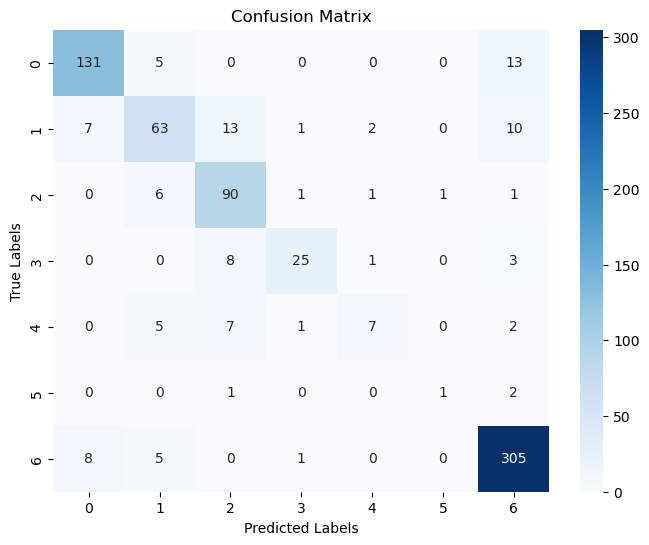

In [173]:
import seaborn as sns

cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<Axes: >

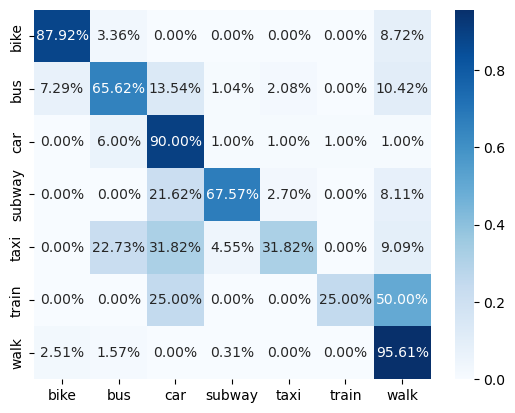

In [174]:
class_names = ['bike', 'bus', 'car', 'subway', 'taxi', 'train', 'walk']
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [175]:
cm

array([[131,   5,   0,   0,   0,   0,  13],
       [  7,  63,  13,   1,   2,   0,  10],
       [  0,   6,  90,   1,   1,   1,   1],
       [  0,   0,   8,  25,   1,   0,   3],
       [  0,   5,   7,   1,   7,   0,   2],
       [  0,   0,   1,   0,   0,   1,   2],
       [  8,   5,   0,   1,   0,   0, 305]])

Cross Validation

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

NOCH UMBENENNEN DIE PARAMETER WEIL UNTEN NEU DEFINIERT

In [177]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],            # Number of trees
    'max_depth': [None, 10, 20, 30],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider at each split
    'bootstrap': [True, False]                 # Use bootstrapping
}

In [178]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

CV-Function: Einfach param_grid und Model ändern bei späteren Modellen! 

In [179]:
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, Y_train)

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, y_pred))

Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.864860324952239
Classification Report:
               precision    recall  f1-score   support

        bike       0.90      0.88      0.89       149
         bus       0.79      0.69      0.73        96
         car       0.77      0.91      0.83       100
      subway       0.83      0.65      0.73        37
        taxi       0.50      0.27      0.35        22
       train       0.50      0.25      0.33         4
        walk       0.91      0.97      0.94       319

    accuracy                           0.86       727
   macro avg       0.74      0.66      0.69       727
weighted avg       0.86      0.86      0.86       727



Zheng Model

In [119]:
f_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train_selected, Y_train)

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)
print("Classification Report:\n", classification_report(Y_test, y_pred))

NameError: name 'X_train_selected' is not defined

In [180]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_grid_search_results(grid_search, save_path=None):
    """
    Plots the mean test accuracy over parameter combinations during GridSearchCV.

    Parameters:
    - grid_search: A fitted GridSearchCV object.
    - save_path: (Optional) Path to save the plot as an image. If None, the plot is displayed.

    Returns:
    - None
    """
    # Convert cv_results_ to a DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Extract the mean test score for each parameter combination
    mean_test_scores = results_df['mean_test_score']
    param_combinations = range(1, len(mean_test_scores) + 1)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(param_combinations, mean_test_scores, marker='o', label='Mean Test Accuracy', linestyle='--')
    plt.title("Grid Search Accuracy Over Parameter Combinations")
    plt.xlabel("Parameter Combination Index")
    plt.ylabel("Mean Test Accuracy")
    plt.ylim(0, 1)  # Accuracy is between 0 and 1
    plt.grid(True)
    plt.legend()

    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

Plot saved to grid_search_accuracy.png


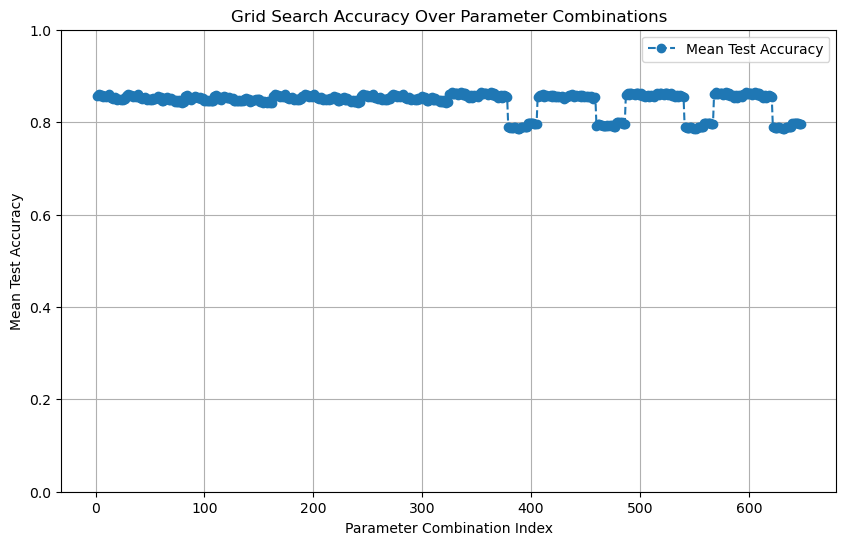

In [181]:
plot_grid_search_results(grid_search, save_path='grid_search_accuracy.png')

Gradient Boosted Tree

In [182]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


In [183]:
gbt = GradientBoostingClassifier(random_state=42)

# Train the model
gbt.fit(X_train, Y_train)

# Make predictions
y_pred = gbt.predict(X_test)
# Evaluate performance
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))

Accuracy: 0.8651994497936726
Classification Report:
               precision    recall  f1-score   support

        bike       0.92      0.87      0.89       149
         bus       0.75      0.70      0.72        96
         car       0.79      0.92      0.85       100
      subway       0.88      0.59      0.71        37
        taxi       0.60      0.55      0.57        22
       train       0.50      0.25      0.33         4
        walk       0.91      0.96      0.94       319

    accuracy                           0.87       727
   macro avg       0.77      0.69      0.72       727
weighted avg       0.86      0.87      0.86       727



In [184]:
y_pred

array(['walk', 'bike', 'bike', 'walk', 'walk', 'walk', 'subway', 'walk',
       'walk', 'bike', 'car', 'walk', 'bus', 'walk', 'car', 'taxi',
       'walk', 'bus', 'bike', 'walk', 'walk', 'walk', 'walk', 'car',
       'walk', 'car', 'walk', 'bike', 'subway', 'subway', 'bike', 'bus',
       'bus', 'bike', 'bus', 'car', 'bike', 'bus', 'car', 'bike', 'walk',
       'walk', 'walk', 'walk', 'bike', 'walk', 'bike', 'car', 'walk',
       'walk', 'bike', 'car', 'car', 'bus', 'car', 'walk', 'bike', 'walk',
       'bike', 'taxi', 'walk', 'walk', 'walk', 'car', 'bus', 'bike',
       'bus', 'train', 'bus', 'car', 'bus', 'car', 'car', 'walk', 'bike',
       'walk', 'walk', 'car', 'bike', 'walk', 'subway', 'walk', 'car',
       'walk', 'bike', 'car', 'subway', 'bus', 'car', 'train', 'walk',
       'bike', 'bike', 'walk', 'car', 'bus', 'bike', 'walk', 'car',
       'bike', 'walk', 'walk', 'walk', 'bus', 'bus', 'car', 'bus', 'bike',
       'walk', 'walk', 'walk', 'car', 'subway', 'walk', 'car', 'bus',


cv

In [185]:
# Define the parameter grid
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                           param_grid=param_grid_gb,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, Y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
best_gbt = grid_search.best_estimator_
y_pred = best_gbt.predict(X_test)
print("Test Accuracy:", accuracy_score(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8703532835317708
Test Accuracy: 0.8789546079779917
Classification Report:
               precision    recall  f1-score   support

        bike       0.90      0.88      0.89       149
         bus       0.81      0.76      0.78        96
         car       0.82      0.92      0.87       100
      subway       0.89      0.68      0.77        37
        taxi       0.77      0.45      0.57        22
       train       0.50      0.25      0.33         4
        walk       0.91      0.96      0.94       319

    accuracy                           0.88       727
   macro avg       0.80      0.70      0.74       727
weighted avg       0.88      0.88      0.87       727



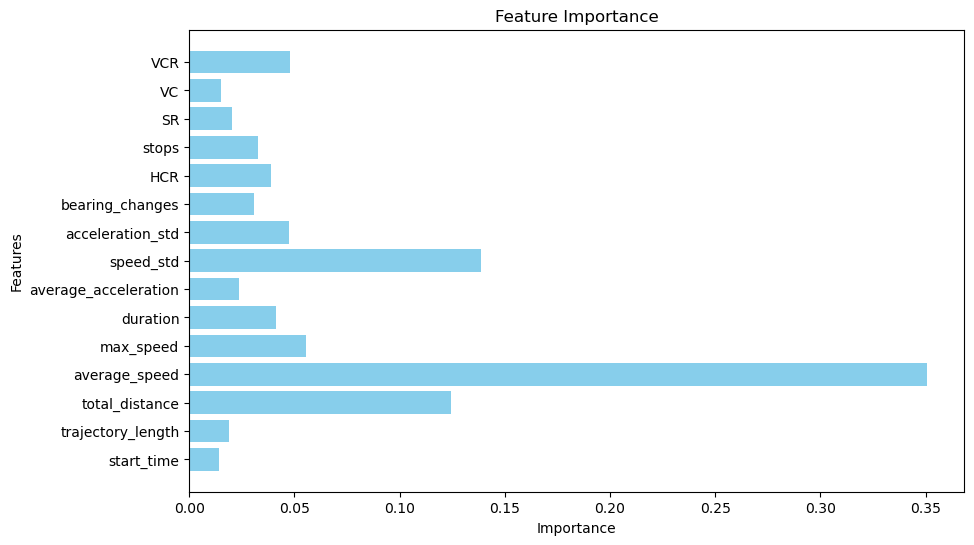

In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature importance from the best model
feature_importance = best_gbt.feature_importances_
features = "start_time", "trajectory_length","total_distance","average_speed",	"max_speed","duration",	"average_acceleration",	"speed_std","acceleration_std",'bearing_changes', 'HCR','stops','SR','VC','VCR'

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [187]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_grid_search_results(grid_search, save_path=None):
    """
    Plots the mean test accuracy over parameter combinations during GridSearchCV.

    Parameters:
    - grid_search: A fitted GridSearchCV object.
    - save_path: (Optional) Path to save the plot as an image. If None, the plot is displayed.

    Returns:
    - None
    """
    # Convert cv_results_ to a DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Extract the mean test score for each parameter combination
    mean_test_scores = results_df['mean_test_score']
    param_combinations = range(1, len(mean_test_scores) + 1)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(param_combinations, mean_test_scores, marker='o', label='Mean Test Accuracy', linestyle='--')
    plt.title("Grid Search Accuracy Over Parameter Combinations")
    plt.xlabel("Parameter Combination Index")
    plt.ylabel("Mean Test Accuracy")
    plt.ylim(0, 1)  # Accuracy is between 0 and 1
    plt.grid(True)
    plt.legend()

    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

Plot saved to grid_search_accuracy.png


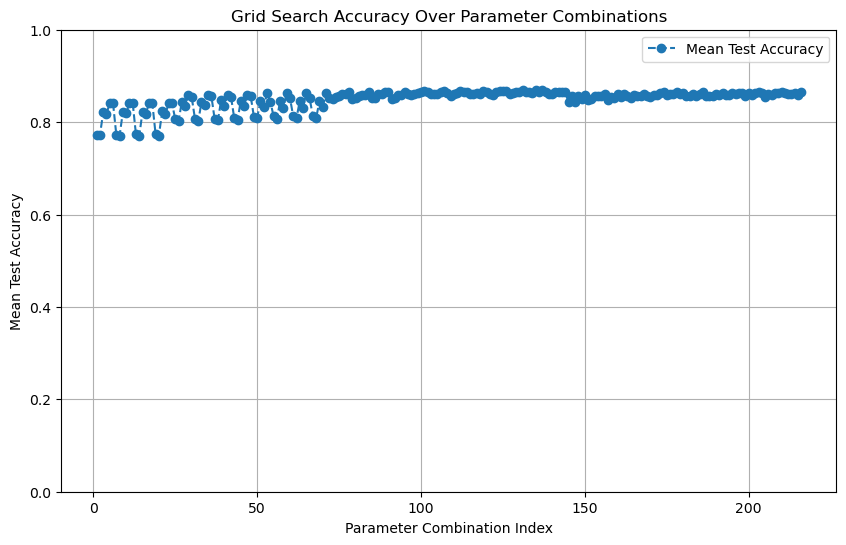

In [188]:
plot_grid_search_results(grid_search, save_path='grid_search_accuracy.png')

PCA

In [189]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [190]:
# Standardize the data to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.89131414, -0.49197393,  2.86655651, ...,  2.1302632 ,
        -0.66770958, -1.09572501],
       [ 0.56308732, -0.17135726, -0.25536869, ..., -0.70653099,
        -0.5205881 , -1.72602749],
       [ 1.05542754,  1.04187326,  1.30356512, ..., -0.70653099,
        -0.67588299, -2.4488108 ],
       ...,
       [-1.07804675, -0.35563195, -0.40865977, ..., -0.59717611,
        -0.36529321, -0.00577339],
       [-0.25747971, -0.30663406, -0.40004351, ..., -0.21940472,
        -0.18139136,  0.50931269],
       [-1.07804675, -0.05844906,  0.52457921, ..., -0.21017495,
        -0.30399259, -1.3057615 ]])

In [191]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

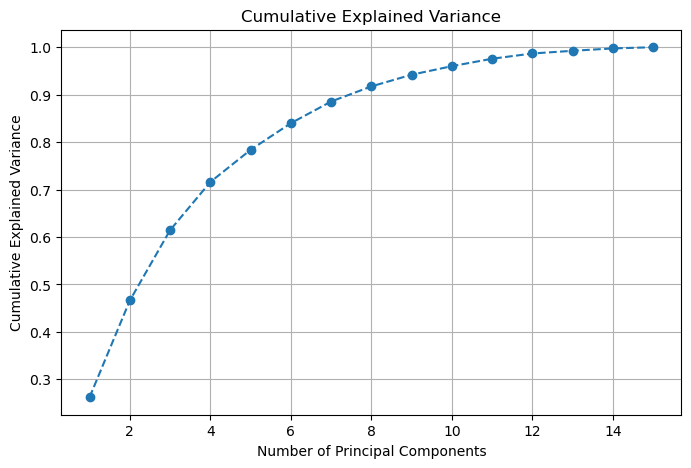

In [192]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()


In [193]:
# Get the loadings (contribution of each feature to the principal components)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=X.columns
)

# Sort features by their absolute contribution to the first principal component (PC1)
important_features = loadings['PC1'].abs().sort_values(ascending=False)
print("Features contributing most to PC1:\n", important_features)

Features contributing most to PC1:
 max_speed               0.360612
speed_std               0.340471
acceleration_std        0.332601
trajectory_length       0.324019
average_speed           0.313198
average_acceleration    0.272928
duration                0.271018
total_distance          0.262126
bearing_changes         0.252041
VCR                     0.216274
VC                      0.210175
stops                   0.196364
HCR                     0.166570
SR                      0.050921
start_time              0.017712
Name: PC1, dtype: float64


In [194]:
min(df['acceleration'])

nan

Deep Learning

In [195]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


One-hot-transform

In [246]:
y_one_hot = pd.get_dummies(Y)
y_one_hot

,bike,bus,car,subway,taxi,train,walk
0,False,False,False,False,False,True,False
1,False,False,False,False,True,False,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...
3667,True,False,False,False,False,False,False
3668,False,False,False,False,False,False,True
3669,False,False,False,False,False,False,True
3670,False,False,False,False,False,False,True


In [247]:
X

,start_time,trajectory_length,total_distance,average_speed,max_speed,duration,average_acceleration,speed_std,acceleration_std,bearing_changes,HCR,stops,SR,VC,VCR
0,14,68,62.604343,0.015478,0.031892,1.063333,6.854169e-07,0.012885,0.000053,10,0.147059,18,0.264706,18,0.264706
1,12,369,3.469740,0.008458,0.016202,0.113333,-3.313765e-06,0.004162,0.001119,30,0.081301,0,0.000000,54,0.146341
2,15,1508,32.998613,0.019483,0.034116,0.496667,2.208877e-05,0.007675,0.000693,9,0.005968,0,0.000000,16,0.010610
3,0,9501,263.810980,0.022617,0.034759,3.763889,-1.473238e-06,0.010152,0.000547,450,0.047363,503,0.052942,595,0.062625
4,15,2179,64.941563,0.026500,0.039892,0.681389,7.373588e-06,0.008655,0.000665,9,0.004130,0,0.000000,20,0.009179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,13,520,2.758249,0.002581,0.023770,0.311667,1.764206e-05,0.001691,0.000716,224,0.430769,3,0.005769,233,0.448077
3668,7,324,0.902732,0.001393,0.006847,0.179444,1.034228e-06,0.000793,0.000386,132,0.407407,7,0.021605,164,0.506173
3669,2,196,0.566144,0.001436,0.005870,0.108889,3.974932e-06,0.000801,0.000430,75,0.382653,2,0.010204,92,0.469388
3670,7,242,0.729351,0.001494,0.004844,0.137222,2.058216e-06,0.000799,0.000443,103,0.425620,11,0.045455,137,0.566116


In [248]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [249]:
y_test

,bike,bus,car,subway,taxi,train,walk
1306,False,False,False,False,False,False,True
120,True,False,False,False,False,False,False
856,True,False,False,False,False,False,False
1554,False,False,False,False,False,False,True
2921,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...
357,False,True,False,False,False,False,False
1670,False,False,False,False,False,False,True
1610,False,False,False,False,False,False,True
693,False,False,False,False,False,False,True


In [250]:
# Initialize the model
model = Sequential()

# Add input and hidden layers
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dropout(0.3))  # Dropout for regularization

# Add output layer
# For binary classification, use 1 output neuron with 'sigmoid'
# For multi-class classification, use n_classes neurons with 'softmax'
output_units = y_train.shape[1] if len(y_train.shape) > 1 else 1
output_activation = 'softmax' if output_units > 1 else 'sigmoid'
model.add(Dense(output_units, activation=output_activation))



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [251]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [252]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [253]:
y_train

,bike,bus,car,subway,taxi,train,walk
2804,False,False,False,True,False,False,False
3523,False,False,False,False,False,False,True
2308,False,False,False,False,False,False,True
1078,True,False,False,False,False,False,False
1444,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...
1147,False,False,False,False,True,False,False
1311,False,False,False,False,False,False,True
877,True,False,False,False,False,False,False
3539,True,False,False,False,False,False,False


Hier nochmal neu

In [254]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    verbose=1)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4895 - loss: 1.5959 - val_accuracy: 0.6753 - val_loss: 1.0488
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6670 - loss: 1.0089 - val_accuracy: 0.6993 - val_loss: 0.9468
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6874 - loss: 0.9150 - val_accuracy: 0.7148 - val_loss: 0.8915
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7234 - loss: 0.8703 - val_accuracy: 0.7216 - val_loss: 0.8545
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7184 - loss: 0.8879 - val_accuracy: 0.7509 - val_loss: 0.8232
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 0.7726 - val_accuracy: 0.7595 - val_loss: 0.8017
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7610 - loss: 0.7605 - val_accuracy: 0.7766 - val_loss: 0.7734
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7621 - loss: 0.7294 - val_accuracy: 0.7852 - val_loss:

In [255]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8288 - loss: 0.5751 
Test Loss: 0.5205904245376587
Test Accuracy: 0.8445667028427124


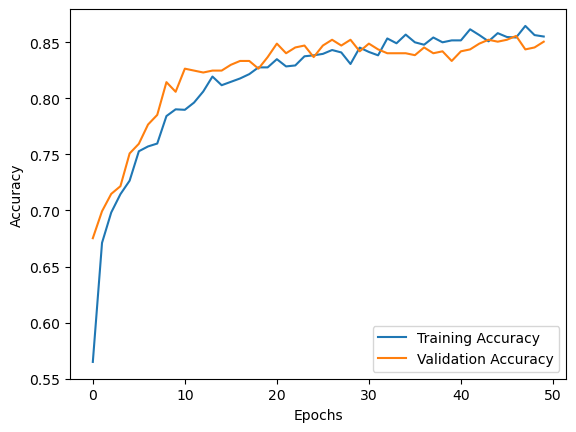

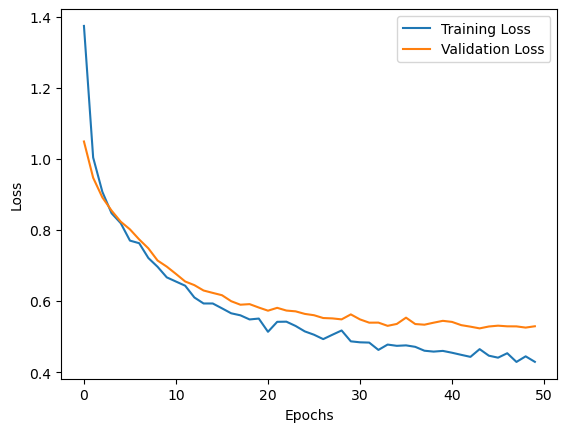

In [256]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


CV

In [257]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [258]:
def create_model(activation='relu', optimizer='adam', dropout_rate=0.3, neurons=128):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(int(neurons / 2), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='softmax'))  # 5 classes
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [259]:

model = KerasClassifier(model=create_model, verbose=0, activation='relu', dropout_rate=0.2, neurons=128, optimizer='adam')


In [260]:
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'neurons': [64, 128, 256],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}


In [261]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_result = grid.fit(X_train, y_train)

# Display the best parameters and accuracy
print("Best Parameters:", grid_result.best_params_)
print("Best Cross-Validation Accuracy:", grid_result.best_score_)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Best Parameters: {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 100, 'neurons': 256, 'optimizer': 'sgd'}
Best Cross-Validation Accuracy: 0.8621046248124861


In [291]:
grid_result

GridSearchCV(cv=3,
             estimator=KerasClassifier(activation='relu', dropout_rate=0.2, model=<function create_model at 0x2e1c05120>, neurons=128, optimizer='adam', verbose=0),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'batch_size': [16, 32, 64],
                         'dropout_rate': [0.2, 0.3, 0.5], 'epochs': [50, 100],
                         'neurons': [64, 128, 256],
                         'optimizer': ['adam', 'sgd']},
             scoring='accuracy', verbose=1)

In [288]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Retrieve the best model
best_model = grid_result.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optionally: Display the confusion matrix
y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_int, y_pred_int)
print("Confusion Matrix:\n", cm)

Test Accuracy: 0.938101788170564
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       149
           1       0.90      0.84      0.87        96
           2       0.92      0.95      0.94       100
           3       0.83      0.92      0.87        37
           4       0.89      0.73      0.80        22
           5       1.00      1.00      1.00         4
           6       0.98      0.97      0.97       319

   micro avg       0.94      0.94      0.94       727
   macro avg       0.92      0.91      0.91       727
weighted avg       0.94      0.94      0.94       727
 samples avg       0.94      0.94      0.94       727

Confusion Matrix:
 [[143   4   0   0   0   0   2]
 [  5  81   4   1   1   0   4]
 [  0   0  95   5   0   0   0]
 [  0   0   1  34   1   0   1]
 [  0   2   3   1  16   0   0]
 [  0   0   0   0   0   4   0]
 [  7   3   0   0   0   0 309]]


In [304]:
best_params

{'activation': 'relu',
 'batch_size': 64,
 'dropout_rate': 0.3,
 'epochs': 100,
 'neurons': 256,
 'optimizer': 'sgd'}

In [309]:
best_params = grid_result.best_params_
best_model = create_model(
    activation=best_params['activation'],
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    neurons=best_params['neurons']
)
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2, 
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2985 - loss: 1.9216 - val_accuracy: 0.6031 - val_loss: 1.6386
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5628 - loss: 1.6109 - val_accuracy: 0.6031 - val_loss: 1.4348
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5843 - loss: 1.4376 - val_accuracy: 0.6031 - val_loss: 1.3144
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5785 - loss: 1.3184 - val_accuracy: 0.6100 - val_loss: 1.2432
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6036 - loss: 1.2360 - val_accuracy: 0.6271 - val_loss: 1.1940
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6025 - loss: 1.2280 - val_accuracy: 0.6409 - val_loss: 1.1572
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6281 - loss: 1.1687 - val_accuracy: 0.6632 - val_loss: 1.1273
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6359 - loss: 1.1481 - val_accuracy: 0.6701 - val_loss: 1.1

In [315]:
y_pred

array([[1.8488118e-02, 2.4326071e-02, 1.9458471e-03, ..., 3.2657022e-03,
        1.0594431e-03, 9.4204247e-01],
       [9.4281614e-01, 8.6239893e-03, 3.1177874e-04, ..., 1.7500123e-03,
        1.8121992e-04, 4.0914282e-02],
       [8.4396446e-01, 5.8332596e-02, 2.6869290e-03, ..., 4.0498064e-03,
        5.5760168e-04, 7.7333815e-02],
       ...,
       [9.4871968e-03, 2.9666526e-03, 1.7379565e-04, ..., 3.6350649e-04,
        1.2331706e-04, 9.8475617e-01],
       [4.8901823e-01, 8.7418390e-04, 1.6637965e-06, ..., 4.8120575e-05,
        1.2750427e-05, 5.0982994e-01],
       [1.5000311e-03, 1.2238680e-01, 6.1268163e-01, ..., 1.2440938e-01,
        3.7763007e-02, 4.2168987e-03]], dtype=float32)

In [305]:
import matplotlib.pyplot as plt

# Extract training history if available
if hasattr(best_model, 'history_'):
    history = best_model.history_

    # Plot training and validation accuracy
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

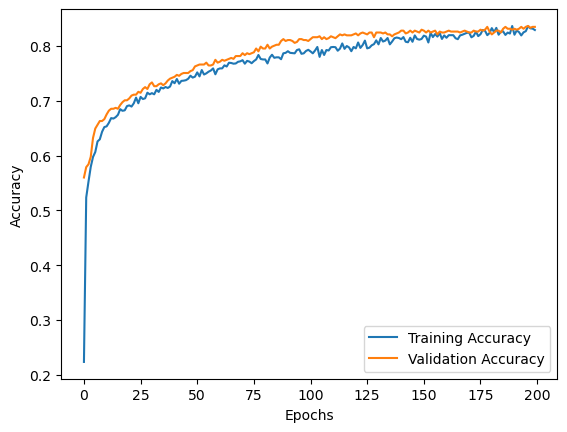

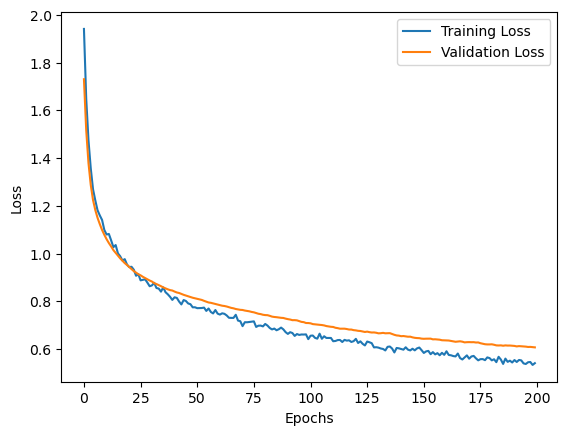

In [307]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [308]:
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame(grid_result.cv_results_)

# Sort by mean test score
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Display the top configurations
print(results_df[['params', 'mean_test_score', 'std_test_score']].head())

                                                params  mean_test_score  \
95   {'activation': 'relu', 'batch_size': 64, 'drop...         0.862105   
59   {'activation': 'relu', 'batch_size': 32, 'drop...         0.861415   
22   {'activation': 'relu', 'batch_size': 16, 'drop...         0.860727   
10   {'activation': 'relu', 'batch_size': 16, 'drop...         0.859696   
119  {'activation': 'tanh', 'batch_size': 16, 'drop...         0.859352   

     std_test_score  
95         0.007164  
59         0.007102  
22         0.008824  
10         0.003912  
119        0.004046  
